In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

import sys

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    def __init__(self, dl, device, transform = None):
        self.dl = dl
        self.device = device
        self.transform = transform
    def __iter__(self):
        if self.transform is None:
            for b in self.dl: 
                yield to_device(b, self.device)
        else:
            for b in self.dl: 
                a = to_device(b, self.device)
                yield [self.transform(a[0]), a[0], a[1]]
    def __len__(self):
        return len(self.dl)

In [3]:
dataset_root = 'D:/datasets/'

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
cifar10_train = torchvision.datasets.CIFAR10(
    root=dataset_root, train=True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(
    root=dataset_root, train=False, transform=transform)
class_idx = {i:n for i,n in enumerate(['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])}
torch.manual_seed(43)
val_size = 5000
train_size = len(cifar10_train) - val_size
cifar10_train, cifar10_val = torch.utils.data.random_split(cifar10_train, [train_size, val_size])

train_ds = torch.utils.data.DataLoader(cifar10_train, batch_size = 16, shuffle = True, pin_memory=True, num_workers = 8)
val_ds = torch.utils.data.DataLoader(cifar10_val, batch_size = 16, shuffle = True, pin_memory=True, num_workers = 8)
test_ds = torch.utils.data.DataLoader(cifar10_test, batch_size = 16, shuffle = True, pin_memory=True, num_workers = 8)
train_loader = DeviceDataLoader(train_ds, device)
val_loader = DeviceDataLoader(val_ds, device)
test_loader = DeviceDataLoader(test_ds, device)

In [4]:
class ImageClassificationBase(torch.nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images + project_lp(torch.randn_like(images, device = device), norm = 2, xi = 20)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images) 
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels) 
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
class VGG(ImageClassificationBase):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.cfg = {
            'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
            'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
            'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
            'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],}
        self.features = self._make_layers(self.cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [5]:
mdl = to_device(VGG('VGG16'), device)
mdl.load_state_dict(torch.load('../models/torch_cifar_vgg.pth'))
mdl = mdl.eval();

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def asr(ds, k, adv_alg = None, verbose = False, **kwargs):
    tot = 0
    acc = 0
    for batch in (tqdm(ds) if verbose else ds):
        if adv_alg is None:
            out = k(batch[0])
        else:
            out = k(batch[0] + adv_alg(batch[0], batch[1], k, **kwargs))
        acc += accuracy(out, batch[1]) * len(batch[1])
        tot += len(batch[1])
    return (1 - acc/tot).item()

In [7]:
def scale_im(im):
    return (im - im.min())/(im.max() - im.min())
def expand_first(im):
    return im.reshape(1, *im.shape)
def show_attack(ims, attacks, mdl):
    if ims.dim() == 3:
        ims = expand_first(ims)
    if attacks.dim() == 3:
        attacks = expand_first(attacks)
    plt.figure()
    f, axarr = plt.subplots(3, ims.shape[0], figsize = (ims.shape[0], 4)) 
    labels = torch.argmax(mdl(ims), axis = 1).cpu().numpy()
    labels_att = torch.argmax(mdl(attacks), axis = 1).cpu().numpy()
    att_batch_size = attacks.shape[0]
    labels_adv = torch.argmax(mdl(ims + attacks), axis = 1).cpu().numpy()
    ims = ims.detach().cpu()
    attacks = attacks.detach().cpu()
    for i in range(ims.shape[0]):
        im = ims[i, :, :, :]
        attack = attacks[i,:,:,:] if att_batch_size > 1 else torch.squeeze(attacks)
        axarr[(0, i) if ims.shape[0] > 1 else 0].imshow(scale_im(im).permute(1,2,0), interpolation='nearest')
        axarr[(0, i) if ims.shape[0] > 1 else 0].set_title(class_idx[int(labels[i])])
        axarr[(0, i) if ims.shape[0] > 1 else 0].axis('off')
        axarr[(1, i) if ims.shape[0] > 1 else 1].imshow(scale_im(attack).permute(1,2,0), interpolation='nearest')
        axarr[(1, i) if ims.shape[0] > 1 else 1].set_title(class_idx[int(labels_att[i] if att_batch_size > 1 else labels_att)])
        axarr[(1, i) if ims.shape[0] > 1 else 1].axis('off')
        axarr[(2, i) if ims.shape[0] > 1 else 2].imshow(scale_im(im + attack).permute(1,2,0), interpolation='nearest')
        axarr[(2, i) if ims.shape[0] > 1 else 2].set_title(class_idx[int(labels_adv[i])])
        axarr[(2, i) if ims.shape[0] > 1 else 2].axis('off')
    plt.show()

In [8]:
def gen_base_affine(x):
    thetas = torch.zeros(x.shape[0], 2, 3)
    thetas[:, 0, 0] = 1
    thetas[:, 1, 1] = 1
    return thetas.to(device)
def diff_affine(x, thetas):
    base_theta = gen_base_affine(x)
    grid = F.affine_grid(base_theta + thetas, x.size(), align_corners = False)
    return F.grid_sample(x, grid, align_corners = False)

In [9]:
def project_lp(v, norm, xi, exact = False, device = device):
    if v.dim() == 4:
        batch_size = v.shape[0]
    else:
        batch_size = 1
    if exact:
        if norm == 2:
            if batch_size == 1:
                v = v * xi/torch.norm(v, p = 2)
            else:
                v = v * xi/torch.norm(v, p = 2, dim = (1,2,3)).reshape((batch_size, 1, 1, 1))
        elif norm == np.inf:        
            v = torch.sign(v) * torch.minimum(torch.abs(v), xi*torch.ones(v.shape, device = device))
        else:
            raise ValueError('L_{} norm not implemented'.format(norm))
    else:
        if norm == 2:
            if batch_size == 1:
                v = v * torch.minimum(torch.ones((1), device = device), xi/torch.norm(v, p = 2))
            else:
                v = v * torch.minimum(xi/torch.norm(v, p = 2, dim = (1,2,3)), torch.ones(batch_size, device = device)).reshape((batch_size, 1, 1, 1))
        elif norm == np.inf:        
            v = torch.sign(v) * torch.minimum(torch.abs(v), xi*torch.ones(v.shape, device = device))
        else:
            raise ValueError('L_{} norm not implemented'.format(norm))
    return v
def fgsm(x, y, k, norm = np.inf, xi = 1e-1, step_size = 1e-1, device = device):
    v = torch.zeros_like(x, device = device, requires_grad = True)
    loss = F.cross_entropy(k(x + v), y)
    loss.backward()
    return project_lp(step_size * torch.sign(v.grad), norm = norm, xi = xi)
def pgd(x, y, k, norm = np.inf, xi = 1e-1, step_size = 1e-2, epochs = 40, random_restart = 4, device = device):
    batch_size = x.shape[0]
    max_loss = F.cross_entropy(k(x), y)
    max_X = torch.zeros_like(x)
    random_delta = torch.rand(size = (batch_size * random_restart, *x.shape[1:]), device = device) - 0.5
    random_delta = project_lp(random_delta, norm = norm, xi = xi, exact = True, device = device)
    x = x.repeat(random_restart, 1, 1, 1)
    y = y.repeat(random_restart)
    for j in range(epochs):
        v = torch.zeros_like(random_delta, device = device, requires_grad = True)
        loss = F.cross_entropy(k(x + random_delta + v), y)
        loss.backward()
        pert = step_size * torch.sign(v.grad)#torch.mean(v.grad)
        random_delta = project_lp(random_delta + pert, norm = norm, xi = xi)
    _,idx = torch.max(F.cross_entropy(mdl(x + random_delta), y, reduction = 'none').reshape(random_restart, batch_size), axis = 0)
    return random_delta[idx * batch_size + torch.arange(batch_size, dtype = torch.int64, device = device)]
def geometric_attack(x, y, k, xi = 1e-1, step_size = 1e-2, epochs = 40, device = device):
    batch_size = x.shape[0]
    v = torch.zeros(batch_size, 2, 3, device = device)
    for i in range(epochs):
        v_ = torch.zeros(batch_size, 2, 3, device = device, requires_grad = True)
        x_ = diff_affine(test_x, v + v_)
        loss = F.cross_entropy(k(x_), y)
        loss.backward()
        pert = step_size * torch.sign(v_.grad)
        v = project_lp(v + pert, norm = np.inf, xi = xi)
    return v

In [127]:
# print('ASR Base - {}, ASR FGSM - {}, ASR PGD - {}'.format(asr(test_loader, mdl).item(), asr(test_loader, mdl, adv_alg = fgsm).item(), asr(test_loader, mdl, adv_alg = pgd).item()))
# (tensor(0.0829), tensor(0.9119), tensor(0.9999))

(tensor(0.0829), tensor(0.9119), tensor(0.9999))

<Figure size 432x288 with 0 Axes>

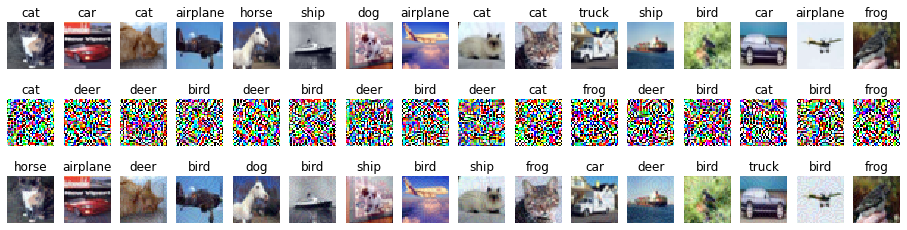

In [65]:
test_x, test_y = next(iter(test_loader))
v2 = pgd(test_x, test_y, mdl)
show_attack(test_x, v2, mdl)

In [87]:
class torch_pca():
    def __init__(self, data, n_components = 512):
        self.n_components = n_components
        transformer = PCA(n_components = self.n_components)
        data = torch.utils.data.DataLoader(data, batch_size = len(data))
        data = next(iter(data))[0].numpy()
        self.data_shape = data.shape[1:]
        transformer.fit(data.reshape(data.shape[0], -1))
        self.explained_variance = sum(transformer.explained_variance_ratio_)
        self.components_ = torch.Tensor(transformer.components_).to(device)
        self.pca_mean_ = torch.Tensor(transformer.mean_).to(device)
    def reduce(self, x):
        x = x.reshape(x.shape[0], -1)
        return torch.matmul(x - self.pca_mean_, self.components_.T)
    def inflate(self, x):
        inf = torch.matmul(x, self.components_) + self.pca_mean_
        return inf.reshape(inf.shape[0], *self.data_shape)
class rl_attack_simulation():
    def __init__(self, mdl = mdl, train_ds = cifar10_train, test_ds = cifar10_test, norm = np.inf, xi = 1e-1, step_size = 1e-2, input_reduction = None, action_reduction = None, **kwargs):
        self.step_size = 1e-2
        self.xi = 1e-1
        self.norm = norm
        self.mdl = mdl
        if input_reduction is None:
            transform = lambda x: x
        elif input_reduction == 'pca':
            if 'in_pca_components' in kwargs:
                self.in_pca = torch_pca(train_ds, n_components = kwargs['in_pca_components'])
            else:
                self.in_pca = torch_pca(train_ds)
            self.in_transform = self.in_pca.reduce
        elif input_reduction == 'nn':
            raise Exception('{} reduction is not implemented'.format(input_reduction))
        else:
            raise Exception('{} reduction is not implemented'.format(input_reduction))
        train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 1, shuffle = True)
        test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 1, shuffle = True)
        self.train_dataset = DeviceDataLoader(train_dl, device, transform = self.in_transform)
        self.test_dataset = DeviceDataLoader(test_dl, device, transform = self.in_transform)
        self.data_shape = torch.tensor(next(iter(self.train_dataset))[1].shape)
        
        self.action_reduction = action_reduction
        if self.action_reduction is None:
            self.action_space = self.data_shape
        elif self.action_reduction == 'geometric':
            self.action_space = torch.tensor([2, 3])
            self.geometric_xi = kwargs.get('geometric_xi', 0.2)
        elif self.action_reduction == 'patch':
            self.patch_size = kwargs.get('patch_size', 5)
            self.action_space = torch.tensor([1, (3 * self.patch_size ** 2) + 2])
        elif self.action_reduction == 'pca':
            if 'out_pca_components' in kwargs:
                self.out_pca = torch_pca(train_ds, n_components = kwargs['out_pca_components'])
            elif 'out_pca_components' in kwargs:
                self.out_pca = self.in_pca
            self.out_transform = self.out_pca.inflate
            self.action_space = torch.tensor([1, self.out_pca.n_components])
        else:
            raise Exception('{} reduction is not implemented'.format(action_space))
        out = self.start()
        if isinstance(out, (list,tuple)):
            self.state_space = [torch.tensor(x.shape) for x in out]
        else:
            self.state_space = torch.tensor(out.shape)
        self.reset_current_action()
        
        self.train_iterator = iter(self.train_dataset)
    
    def reset_current_action(self):
        self.current_action = torch.zeros(*self.action_space, device = device)
    
    def start(self):
        return self.reset()
    
    def reset(self):
        self.reset_current_action()
        try:
            self.xt, self.x, self.y = next(self.train_iterator)
        except:
            self.train_iterator = iter(self.train_dataset)
            self.xt, self.x, self.y = next(self.train_iterator)
        self.x_base = torch.clone(self.x)
        return self.state_space_output()
    
    def state_space_output(self):
        #return self.xt, self.mdl(self.x), self.y
        return self.xt, F.cross_entropy(self.mdl(self.x), self.y).reshape(1)
    
    def step(self, move):
        move = move * self.step_size
        if self.action_reduction is None:
            self.current_action = project_lp(self.current_action + move, norm = self.norm, xi = self.xi)
            self.x = self.x + self.current_action
        elif self.action_reduction == 'geometric':
            self.current_action = project_lp(self.current_action + move, norm = np.inf, xi = self.geometric_xi)
            self.x = diff_affine(self.x_base, self.current_action)
        elif self.action_reduction == 'patch':
            self.current_action[:, :-2] = project_lp(self.current_action[:, :-2] + move[:, :-2], norm = self.norm, xi = self.xi)
            self.current_action[:, -2:] = project_lp(self.current_action[:, -2:] + move[:, -2:], norm = np.inf, xi = 1)
            patch_x = int((self.current_action[:, -2] + 1)/2 * (self.data_shape[2] - self.patch_size))
            patch_y = int((self.current_action[:, -1] + 1)/2 * (self.data_shape[3] - self.patch_size))
            self.x = self.x_base
            self.x[:, :, patch_x:patch_x + self.patch_size, patch_y:patch_y + self.patch_size] += move[:,:-2].reshape(3, self.patch_size, self.patch_size)
        elif self.action_reduction == 'pca':
            raise Exception('{} reduction is not implemented'.format(action_space))
        else:
            raise Exception('{} reduction is not implemented'.format(action_space))
        self.xt = self.in_transform(self.x)
        return self.state_space_output()
    

In [88]:
sim = rl_attack_simulation(step_size = 1e-1, xi = 1, input_reduction = 'pca', n_components = 512, action_reduction = 'patch', patch_size = 5)

In [89]:
print('State Space: {}, Action Space: {}'.format(sim.state_space, sim.action_space))

State Space: [tensor([  1, 512]), tensor([1])], Action Space: tensor([ 1, 77])


In [90]:
x, loss = sim.start()

In [91]:
random_move = torch.zeros((1, 3 * 5 * 5 + 2)).uniform_(-1, 1).cuda()
x1, loss1 = sim.step(random_move)